In [20]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.transform import resize
import pandas as pd

# Set device to CPU
device = torch.device("cpu")
print(f"Using device: {device}")

# Load locally saved EfficientNet model
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)  # Adjust for binary classification
state_dict = torch.load("efficientnet_cats_dogs.pth", map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# Image preprocessing
def preprocess_image(img_path, target_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return img_tensor, np.array(img)

# Grad-CAM implementation
def make_gradcam_heatmap(model, img_tensor, target_layer):
    gradients = []
    activations = []

    def hook_grad(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    def hook_activation(module, input, output):
        activations.append(output.detach())

    # Attach hooks
    handle_grad = target_layer.register_full_backward_hook(hook_grad)
    handle_activation = target_layer.register_forward_hook(hook_activation)

    # Forward pass
    output = model(img_tensor)
    target_class = output.argmax(dim=1).item()
    loss = output[0, target_class]

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Compute Grad-CAM
    gradients_np = gradients[0].numpy()
    activations_np = activations[0].numpy()
    weights = np.mean(gradients_np, axis=(2, 3))  # Global average pooling
    heatmap = np.sum(weights[:, :, None, None] * activations_np, axis=1).squeeze()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap) if np.max(heatmap) > 0 else 1  # Normalize

    # Remove hooks
    handle_grad.remove()
    handle_activation.remove()

    return heatmap

# Integrated Gradients
def compute_integrated_gradients(model, img_tensor, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(img_tensor).to(device)  # Baseline is all zeros by default

    # Generate scaled inputs
    scaled_inputs = [baseline + (float(i) / steps) * (img_tensor - baseline) for i in range(steps + 1)]

    # Compute gradients
    gradients = []
    for scaled_input in scaled_inputs:
        scaled_input.requires_grad = True
        output = model(scaled_input)
        loss = output[0, target_class]
        model.zero_grad()
        loss.backward()
        gradients.append(scaled_input.grad.detach().numpy())

    # Average gradients and multiply by input
    avg_gradients = np.mean(gradients, axis=0)
    integrated_gradients = (img_tensor.detach().numpy() - baseline.numpy()) * avg_gradients
    integrated_gradients = np.abs(integrated_gradients).sum(axis=1).squeeze()  # Aggregate across channels
    return integrated_gradients / np.max(integrated_gradients) if np.max(integrated_gradients) > 0 else integrated_gradients

# LIME explanation function
def explain_with_lime(model, img_tensor, original_img):
    def predict_function(imgs):
        imgs_tensor = torch.stack([transforms.ToTensor()(Image.fromarray((img * 255).astype('uint8'))) for img in imgs]).to(device)
        outputs = model(imgs_tensor)
        return outputs.softmax(dim=1).detach().numpy()

    img_np = original_img / 255.0  # Normalize to [0, 1]
    img_np = img_np.astype('float32')  # Ensure dtype is float32

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img_np, predict_function, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
    return mask.astype('float32')

# Resize function
def resize_to_input_size(explanation, target_size):
    """
    Resize explanation to match target size.
    Args:
        explanation: 2D explanation map (e.g., Grad-CAM or Integrated Gradients).
        target_size: Tuple (height, width) of the target dimensions.
    Returns:
        Resized explanation map.
    """
    return resize(explanation, target_size, preserve_range=True)

# Sparsity metric
def compute_sparsity(explanation):
    total_pixels = explanation.size
    non_zero_pixels = np.sum(explanation > 0)
    sparsity = 1 - (non_zero_pixels / total_pixels)
    return sparsity

# Metrics function
def compute_metrics(explanation, prediction):
    metrics = {}

    # Resize explanation to match prediction dimensions if necessary
    if explanation.shape != prediction.shape[1:]:
        explanation = resize_to_input_size(explanation, prediction.shape[1:])

    # Flatten explanation and prediction for compatibility
    explanation_flat = explanation.flatten()
    prediction_flat = prediction.mean(axis=0).flatten()  # Average across channels

    # Ensure same size for both arrays
    min_size = min(len(explanation_flat), len(prediction_flat))
    explanation_flat = explanation_flat[:min_size]
    prediction_flat = prediction_flat[:min_size]

    # Faithfulness (using correlation)
    metrics['Faithfulness'] = np.corrcoef(explanation_flat, prediction_flat)[0, 1]

    # Sparsity
    metrics['Sparsity'] = compute_sparsity(explanation)

    # Complexity
    metrics['Complexity'] = np.sum(explanation > 0.5)

    return metrics

# Save heatmap as an image
def save_heatmap(image, heatmap, output_path, cmap='jet', alpha=0.5):
    heatmap_resized = resize_to_input_size(heatmap, image.shape[:2])
    heatmap_colored = plt.get_cmap(cmap)(heatmap_resized)[:, :, :3]
    overlay = alpha * heatmap_colored + (1 - alpha) * image / 255.0
    plt.imsave(output_path, overlay)

# Process folder
def process_folder(model, input_folder, output_folder, target_layer, target_size=(224, 224)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    results = []

    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)
        if not (file_name.lower().endswith(('.jpg', '.jpeg', '.png'))):
            continue  # Skip non-image files

        try:
            # Preprocess image
            img_tensor, original_img = preprocess_image(file_path, target_size)
            target_class = model(img_tensor).argmax(dim=1).item()

            # Generate explanations
            gradcam = make_gradcam_heatmap(model, img_tensor, target_layer)
            integrated_gradients = compute_integrated_gradients(model, img_tensor, target_class)
            lime_mask = explain_with_lime(model, img_tensor, original_img)

            # Resize explanations to match input image size
            gradcam = resize_to_input_size(gradcam, original_img.shape[:2])
            integrated_gradients = resize_to_input_size(integrated_gradients, original_img.shape[:2])
            lime_mask = resize_to_input_size(lime_mask, original_img.shape[:2])

            # Compute metrics
            gradcam_metrics = compute_metrics(gradcam, img_tensor.cpu().squeeze().numpy())
            integrated_metrics = compute_metrics(integrated_gradients, img_tensor.cpu().squeeze().numpy())
            lime_metrics = compute_metrics(lime_mask, img_tensor.cpu().squeeze().numpy())

            # Save heatmaps
            save_heatmap(original_img, gradcam, os.path.join(output_folder, f"{file_name}_gradcam.png"))
            save_heatmap(original_img, integrated_gradients, os.path.join(output_folder, f"{file_name}_integrated.png"))
            save_heatmap(original_img, lime_mask, os.path.join(output_folder, f"{file_name}_lime.png"))

            # Store results
            results.append({
                "File": file_name,
                "Grad-CAM": gradcam_metrics,
                "Integrated Gradients": integrated_metrics,
                "LIME": lime_metrics
            })

        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            continue

    return results

# Specify the target layer
target_layer = model.features[-1]  # Last convolutional layer in EfficientNet

# Input and output folders
input_folder = "Test"  # Folder containing input images
output_folder = "xai_outputs"  # Folder for saving outputs

# Process the folder
results = process_folder(model, input_folder, output_folder, target_layer)

# Save results to a text file
results_df = pd.DataFrame(results)
results_txt_path = os.path.join(output_folder, "metrics_results.txt")
results_df.to_csv(results_txt_path, index=False, sep="\t")

print(f"Metrics saved to {results_txt_path}")


Using device: cpu


/Users/atulsanthosh/Documents/PyCharm/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/atulsanthosh/Documents/PyCharm/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/yw/964l7rz55xx_wxnr0htdygww0000gn/T/ipykernel_4160/2050368755.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future

Metrics saved to xai_outputs/metrics_results.txt


In [21]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

def visualize_heatmaps_with_metrics(image_path, gradcam_path, integrated_path, lime_path, metrics, output_path):
    """
    Generate a 2x2 plot with the original image, Grad-CAM, Integrated Gradients, and LIME heatmaps
    along with their corresponding metrics and save the visualization.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Load images
    original_img = mpimg.imread(image_path)
    gradcam_img = mpimg.imread(gradcam_path)
    integrated_img = mpimg.imread(integrated_path)
    lime_img = mpimg.imread(lime_path)

    # Original image
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    # Grad-CAM
    axes[0, 1].imshow(gradcam_img)
    gradcam_metrics = metrics.get("Grad-CAM", {})
    axes[0, 1].set_title(f"Grad-CAM\nFaithfulness: {gradcam_metrics.get('Faithfulness', 'N/A')}\n"
                         f"Sparsity: {gradcam_metrics.get('Sparsity', 'N/A'):.4f}\n"
                         f"Complexity: {gradcam_metrics.get('Complexity', 'N/A')}")
    axes[0, 1].axis('off')

    # Integrated Gradients
    axes[1, 0].imshow(integrated_img)
    integrated_metrics = metrics.get("Integrated Gradients", {})
    axes[1, 0].set_title(f"Integrated Gradients\nFaithfulness: {integrated_metrics.get('Faithfulness', 'N/A')}\n"
                         f"Sparsity: {integrated_metrics.get('Sparsity', 'N/A'):.4f}\n"
                         f"Complexity: {integrated_metrics.get('Complexity', 'N/A')}")
    axes[1, 0].axis('off')

    # LIME
    axes[1, 1].imshow(lime_img)
    lime_metrics = metrics.get("LIME", {})
    axes[1, 1].set_title(f"LIME\nFaithfulness: {lime_metrics.get('Faithfulness', 'N/A')}\n"
                         f"Sparsity: {lime_metrics.get('Sparsity', 'N/A'):.4f}\n"
                         f"Complexity: {lime_metrics.get('Complexity', 'N/A')}")
    axes[1, 1].axis('off')

    # Save visualization
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close(fig)


def generate_visualizations(input_folder, heatmap_folder, results_txt_path, output_visualizations_folder):
    """
    Generate heatmap visualizations with metrics for all images in the input folder.
    """
    if not os.path.exists(output_visualizations_folder):
        os.makedirs(output_visualizations_folder)

    # Load metrics from the text file
    results_df = pd.read_csv(results_txt_path, sep='\t')

    for _, row in results_df.iterrows():
        file_name = row["File"]
        gradcam_metrics = eval(row["Grad-CAM"])
        integrated_metrics = eval(row["Integrated Gradients"])
        lime_metrics = eval(row["LIME"])

        # Paths to images
        image_path = os.path.join(input_folder, file_name)
        gradcam_path = os.path.join(heatmap_folder, f"{file_name}_gradcam.png")
        integrated_path = os.path.join(heatmap_folder, f"{file_name}_integrated.png")
        lime_path = os.path.join(heatmap_folder, f"{file_name}_lime.png")
        output_path = os.path.join(output_visualizations_folder, f"{file_name}_visualization.png")

        # Collect metrics for the image
        metrics = {
            "Grad-CAM": gradcam_metrics,
            "Integrated Gradients": integrated_metrics,
            "LIME": lime_metrics
        }

        # Generate visualization
        visualize_heatmaps_with_metrics(image_path, gradcam_path, integrated_path, lime_path, metrics, output_path)
        print(f"Saved visualization for {file_name} at {output_path}")


# Input and output paths
input_folder = "Test"  # Folder containing original images
heatmap_folder = "xai_outputs"  # Folder containing Grad-CAM, Integrated Gradients, and LIME heatmaps
results_txt_path = os.path.join(heatmap_folder, "metrics_results.txt")  # Path to the metrics text file
output_visualizations_folder = "visualizations"  # Folder to save visualizations

# Generate visualizations
generate_visualizations(input_folder, heatmap_folder, results_txt_path, output_visualizations_folder)


Saved visualization for american_bulldog_72.jpg at visualizations/american_bulldog_72.jpg_visualization.png
Saved visualization for american_bulldog_75.jpg at visualizations/american_bulldog_75.jpg_visualization.png
Saved visualization for american_bulldog_76.jpg at visualizations/american_bulldog_76.jpg_visualization.png
Saved visualization for Egyptian_Mau_91.jpg at visualizations/Egyptian_Mau_91.jpg_visualization.png
Saved visualization for Russian_Blue_49.jpg at visualizations/Russian_Blue_49.jpg_visualization.png


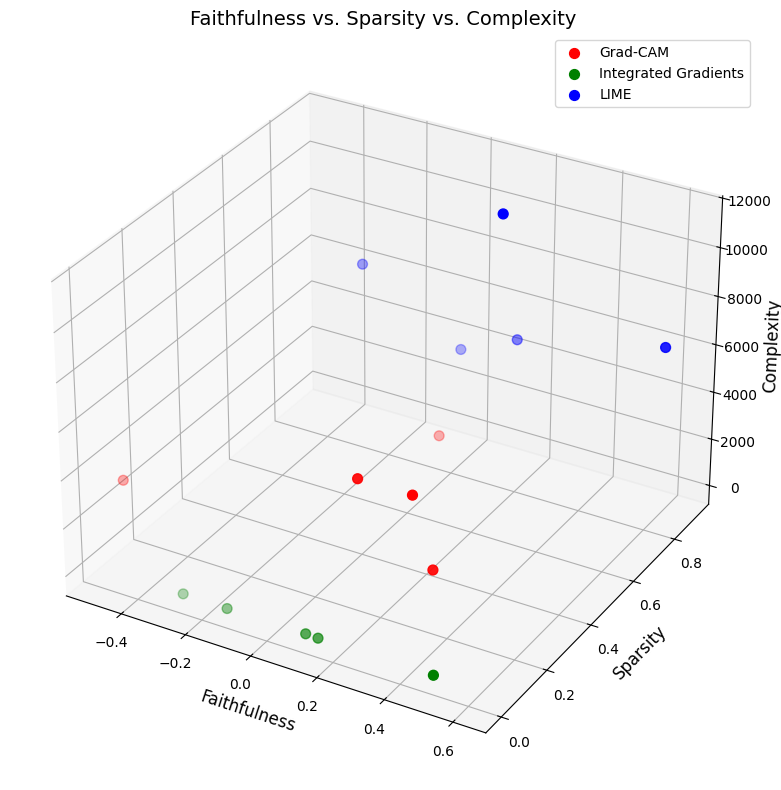

3D plot saved at faithfulness_sparsity_complexity_plot.png


In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_faithfulness_sparsity_complexity(results_txt_path, output_path):
    """
    Generate a 3D scatter plot for Faithfulness, Sparsity, and Complexity.
    Args:
        results_txt_path: Path to the metrics text file.
        output_path: Path to save the 3D plot as an image.
    """
    # Load metrics from the text file
    results_df = pd.read_csv(results_txt_path, sep='\t')

    # Initialize data containers for each method
    methods = ["Grad-CAM", "Integrated Gradients", "LIME"]
    data = {method: {"Faithfulness": [], "Sparsity": [], "Complexity": []} for method in methods}

    # Extract metrics for each method
    for _, row in results_df.iterrows():
        for method in methods:
            metrics = eval(row[method])  # Convert string to dictionary
            data[method]["Faithfulness"].append(metrics.get("Faithfulness", 0))
            data[method]["Sparsity"].append(metrics.get("Sparsity", 0))
            data[method]["Complexity"].append(metrics.get("Complexity", 0))

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each method
    colors = ['r', 'g', 'b']  # Colors for Grad-CAM, Integrated Gradients, LIME
    for method, color in zip(methods, colors):
        ax.scatter(
            data[method]["Faithfulness"],
            data[method]["Sparsity"],
            data[method]["Complexity"],
            label=method,
            color=color,
            s=50  # Marker size
        )

    # Set axis labels
    ax.set_xlabel("Faithfulness", fontsize=12)
    ax.set_ylabel("Sparsity", fontsize=12)
    ax.set_zlabel("Complexity", fontsize=12)

    # Set plot title
    ax.set_title("Faithfulness vs. Sparsity vs. Complexity", fontsize=14)

    # Add legend
    ax.legend()

    # Save the plot
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    print(f"3D plot saved at {output_path}")


# Paths
results_txt_path = "xai_outputs/metrics_results.txt"  # Path to metrics text file
output_plot_path = "faithfulness_sparsity_complexity_plot.png"  # Path to save the plot

# Generate the 3D plot
plot_faithfulness_sparsity_complexity(results_txt_path, output_plot_path)
